In [2]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET

In [3]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("andrewmvd/face-mask-detection")

# print("Path to dataset files:", path)

In [4]:
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    annotations = []
    for obj in root.findall('object'):
        filename = root.find('filename').text
        label = obj.find('name').text
        bbox = obj.find('bndbox')
        coords = {
            'xmin': int(bbox.find('xmin').text),
            'ymin': int(bbox.find('ymin').text),
            'xmax': int(bbox.find('xmax').text),
            'ymax': int(bbox.find('ymax').text)
        }
        annotations.append({'filename': filename, 'label': label, 'bbox': coords})
    return annotations

In [5]:
ANNOTATION_PATH = 'face-mask-detection/versions/1/annotations'
xml_files = [os.path.join(ANNOTATION_PATH, filename) for filename in os.listdir(ANNOTATION_PATH) if filename.endswith('.xml')]

data = []
for xml_file in xml_files:
    annotations = parse_xml(xml_file)

    for annotation in annotations:
        data.append([annotation['filename'], annotation['label'], annotation['bbox']])

df = pd.DataFrame(data, columns=['filename', 'label', 'bbox'])
df['label'].value_counts()


label
with_mask                3232
without_mask              717
mask_weared_incorrect     123
Name: count, dtype: int64

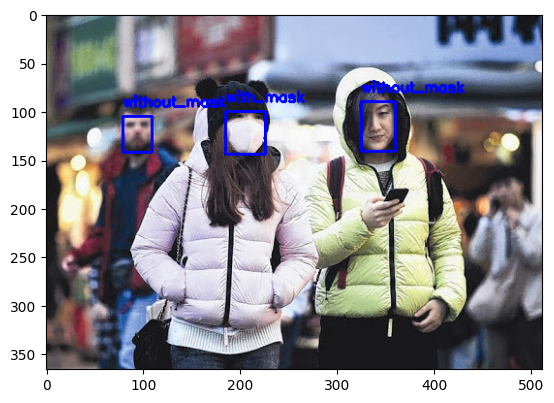

In [6]:
def visualize_annotation(image_path, annotations):
    image = cv2.imread(image_path)

    for ann in annotations:
        bbox = ann['bbox']
        cv2.rectangle(image, (bbox['xmin'], bbox['ymin']), (bbox['xmax'], bbox['ymax']), (255, 0, 0), 2)
        cv2.putText(image, ann['label'], (bbox['xmin'], bbox['ymin'] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
visualize_annotation('face-mask-detection/versions/1/images/maksssksksss0.png', parse_xml('face-mask-detection/versions/1/annotations/maksssksksss0.xml'))

In [ ]:
IMAGE_PATH = 'face-mask-detection/versions/1/images/'
label_pair = {
    'with_mask': 0,
    'without_mask': 1,
    'mask_weared_incorrect': 2
}

face_images = []
face_labels = []

for i in range(len(df)):
    row = df.iloc[i]
    bbox = row['bbox']
    image = cv2.imread(IMAGE_PATH + row['filename'])
    image = image[bbox['ymin']:bbox['ymax'], bbox['xmin']:bbox['xmax']]
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Apply Gaussian blur to remove noise
    image = cv2.GaussianBlur(image, (1, 1), 0)
    image = cv2.resize(image, (224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)

    face_images.append(image)
    face_labels.append(label_pair[row['label']])

face_images = np.array(face_images, dtype='float32')
face_labels = np.array(face_labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


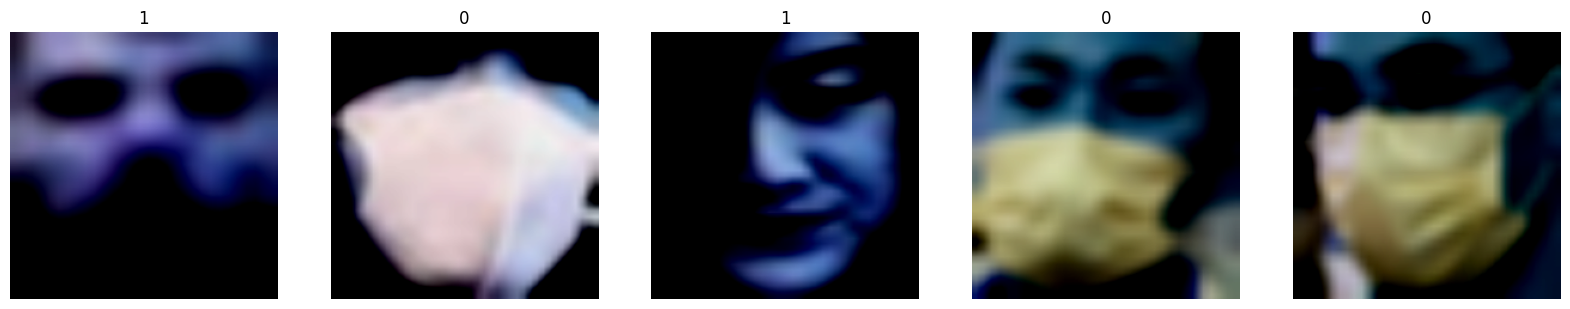

In [16]:
#Display the images
def display_images(images, labels, n=5):
    plt.figure(figsize=(20, 10))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.title(labels[i])
        plt.axis('off')
    plt.show()

display_images(face_images, face_labels, n=5)

In [8]:
augmentation = ImageDataGenerator(
    zoom_range = 0.1,
    shear_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    rotation_range = 25,
    fill_mode = 'nearest'
)


In [ ]:
# #add the augumented data to the dataset
# face_images_augmented = []
# face_labels_augmented = []
# for i in range(len(face_images)):
#     image = face_images[i].reshape((1,) + face_images[i].shape)
#     label = face_labels[i].reshape((1,) + face_labels[i].shape)
#     j = 0
#     for x_batch, y_batch in augmentation.flow(image, label, batch_size=1):
#         face_images_augmented.append(x_batch[0])
#         face_labels_augmented.append(y_batch[0])
#         j += 1
#         if j >= 5:
#             break

# face_images_augmented = np.array(face_images_augmented)
# face_labels_augmented = np.array(face_labels_augmented)

# print(face_images_augmented.shape)
# print(face_labels_augmented.shape)


MemoryError: Unable to allocate 11.4 GiB for an array with shape (20360, 224, 224, 3) and data type float32

In [10]:
train_x, test_val_x, train_y, test_val_y = train_test_split(face_images, face_labels, test_size=0.3, shuffle=True, stratify=face_labels)
test_x, val_x, test_y, val_y = train_test_split(test_val_x, test_val_y, test_size=0.5, shuffle=True, stratify=test_val_y)

train_y_cat = tf.keras.utils.to_categorical(train_y)
val_y_cat = tf.keras.utils.to_categorical(val_y)
test_y_cat = tf.keras.utils.to_categorical(test_y)

print(train_x.shape, val_x.shape, test_x.shape)
print(train_y_cat.shape, val_y_cat.shape, test_y_cat.shape)


(2850, 224, 224, 3) (611, 224, 224, 3) (611, 224, 224, 3)
(2850, 3) (611, 3) (611, 3)


In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

# Clear any previous models/sessions

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,347 (42.61 MB)

 Trainable params: 11,169,347 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 57s 509ms/step - accuracy: 0.8274 - loss: 0.7470 - val_accuracy: 0.9394 - val_loss: 0.2397
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 42s 469ms/step - accuracy: 0.9316 - loss: 0.2490 - val_accuracy: 0.9476 - val_loss: 0.1778
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 41s 455ms/step - accuracy: 0.9385 - loss: 0.1988 - val_accuracy: 0.9394 - val_loss: 0.2557
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 41s 458ms/step - accuracy: 0.9421 - loss: 0.1944 - val_accuracy: 0.9427 - val_loss: 0.1888
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 41s 458ms/step - accuracy: 0.9478 - loss: 0.1792 - val_accuracy: 0.9493 - val_loss: 0.1577
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 41s 458ms/step - accuracy: 0.9461 - loss: 0.1757 - val_accuracy: 0.9607 - val_loss: 0.1419
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 41s 459ms/step - accuracy: 0.9485 - loss: 0.1452 - val_accuracy: 0.9574 - val_loss: 0.1523
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 42s 465ms/step - accuracy: 0.9525 - loss: 0.1426 - val_accu

Text(0, 0.5, 'Accuracy')

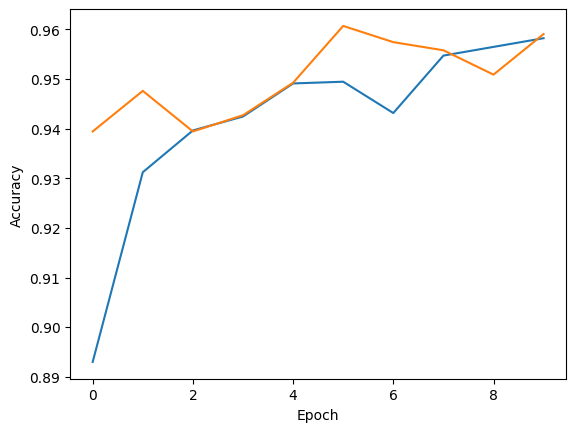

In [24]:
model.fit(train_x, train_y_cat, epochs=10, batch_size=32, validation_data=(val_x, val_y_cat))
history = model.history.history

# Plot training and validation accuracy
plt.plot(history['accuracy'], label='accuracy')
plt.plot(history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step


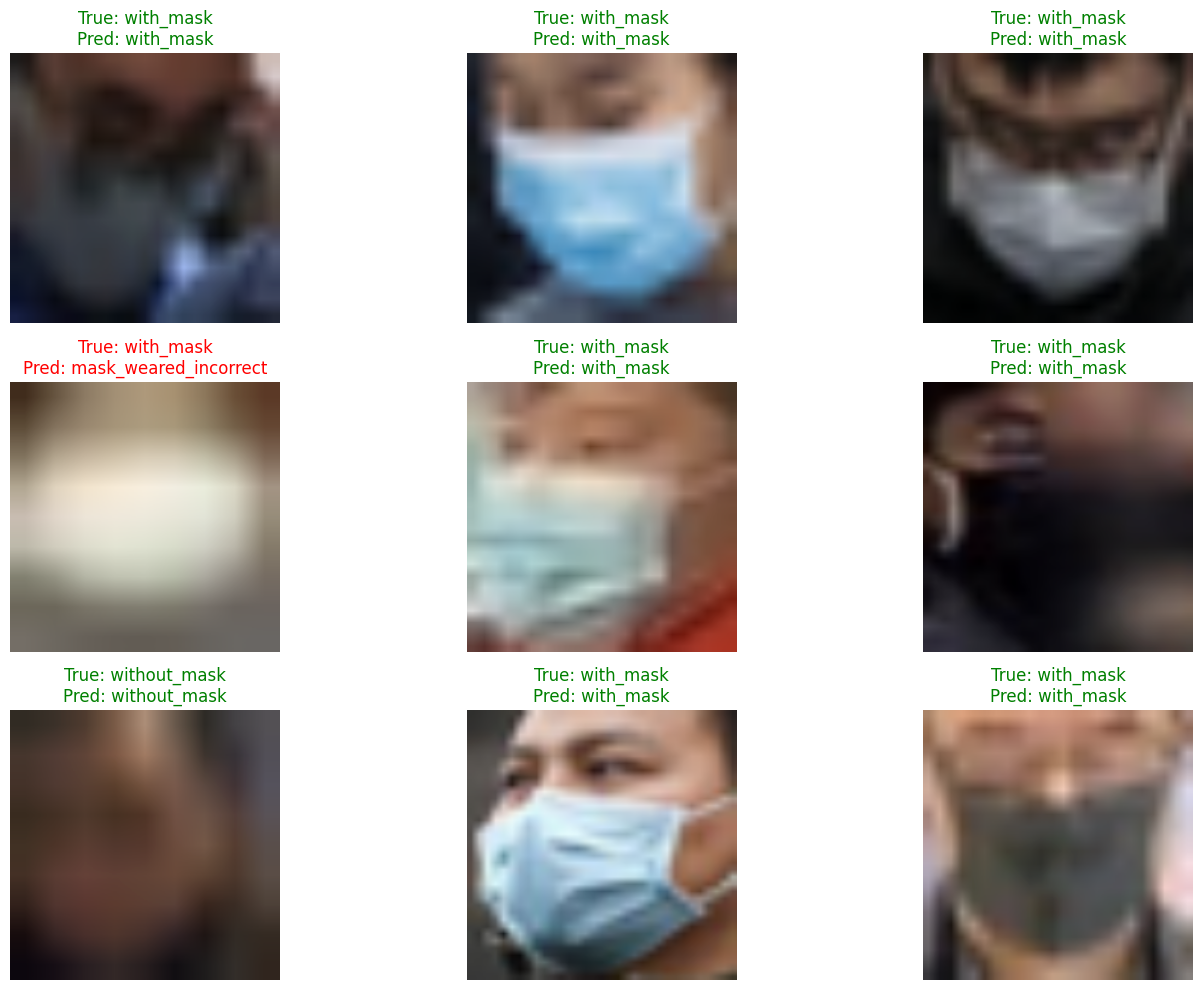

In [26]:
# Get predictions for test data
predictions = model.predict(test_x)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_y

# Create a mapping from numeric labels back to string labels
label_mapping = {0: 'with_mask', 1: 'without_mask', 2: 'mask_weared_incorrect'}

# Plot a grid of images with their predictions
plt.figure(figsize=(15, 10))
for i in range(9):  # Show first 9 images
    plt.subplot(3, 3, i+1)
    plt.imshow(cv2.cvtColor(((test_x[i] + 1) * 127.5).astype(np.uint8), cv2.COLOR_BGR2RGB))
    
    true_label = label_mapping[true_labels[i]]
    pred_label = label_mapping[predicted_labels[i]]
    color = 'green' if true_labels[i] == predicted_labels[i] else 'red'
    
    plt.title(f'True: {true_label}\nPred: {pred_label}', color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()